## Information from papers

## Dendrogram parameters
Σmin = 0.1 g cm−2. We then search for fragmentation in increments of mass surface den- sity ∆Σinc = 0.025 g cm−2 . This is equivalent to the method used by Cheng et al. (2018), if their 1σ noise level of ??? is equivalent to a mass surface density of 0.025 g cm−2 , which is the fiducial conversion factor adopted by these authors. For the third parameter, we require that each core have a projected area equivalent to at least two zones at the finest grid scale, i.e., an area of 2.44 × 10−4 pc2. 


## Qparameter
Qparameter (Cartwright & Whitworth 2004), which is the ratio between the mean length of the edges of the minimumspanning tree (MST) of the cluster,¯m, and the mean separation between stars in the cluster,¯s.

Normalised Correlation Length ¯s (i.e. the mean separation between stars, divided by the overall radius of the
cluster)

Normalised Mean Edge Length ¯m (i.e. the mean length of the branches of the tree, divided by (NtotalA)^1/2/(Ntotal−1), where A is the area of the cluster and Ntotal is the number of stars)

A value Q<0.785 means the cluster is relatively substructured with a lower value corresponding to more clumpiness. In contrast,Q>0.785 means the cluster has an overall radial structure/concentration, with a higher Q value indicating that it is more concentrated in the center

## Imports 

In [5]:
#Reading data and plotting
import yt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
#Dendrogram
from astrodendro import Dendrogram
from astrodendro.analysis import PPStatistic
#MST
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import minimum_spanning_tree
#Histograms
import collections

plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100

## Plotting simulation 

yt : [INFO     ] 2021-06-14 18:44:05,709 Parameters: current_time              = 0.047999984165473 code_time
yt : [INFO     ] 2021-06-14 18:44:05,710 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-06-14 18:44:05,710 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-14 18:44:05,711 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-14 18:44:05,712 Parameters: cosmological_simulation   = 0.0


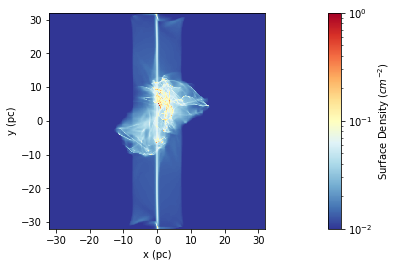

In [2]:
fname = "./frb2048/v10_B10_th60_b05_0030_proj_frb.h5"
ds = yt.load(fname)
ulength = ds.length_unit
normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
north = [0, 1, 0]
width = 0.5
center = [0.5, 0.5, 0.5]
resol = 2048
#dens = yt.off_axis_projection(ds, center, normal, width, resol, "density", north_vector=north).to_ndarray()
data=ds.all_data()["density"]
num=int(np.sqrt(np.shape(data)[0]))

# get density field and convert back to 2-d array
dens = data.reshape(num,-1)

dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=2)
dp = dendro.plotter()

fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

l = - 0.5 * width * ulength.in_units("pc")
r = + 0.5 * width * ulength.in_units("pc")
b = - 0.5 * width * ulength.in_units("pc")
t = + 0.5 * width * ulength.in_units("pc")

im = ax.imshow(dens,
    norm=LogNorm(vmin=1e-2, vmax=1.0), 
    aspect="equal",
    origin="lower",
    extent=(l,r,b,t),
    cmap="RdYlBu_r"
)

ax.set_xlabel("x (pc)")
ax.set_ylabel("y (pc)")

cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) #this place the axis
cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
cbar.set_label(r"Surface Density ($cm^{-2}$)")


## MST on top of simulation 

### OFFAXIS 

(4096, 4096)
Number of cores:  184
Q_normalised: 0.34476924069897374


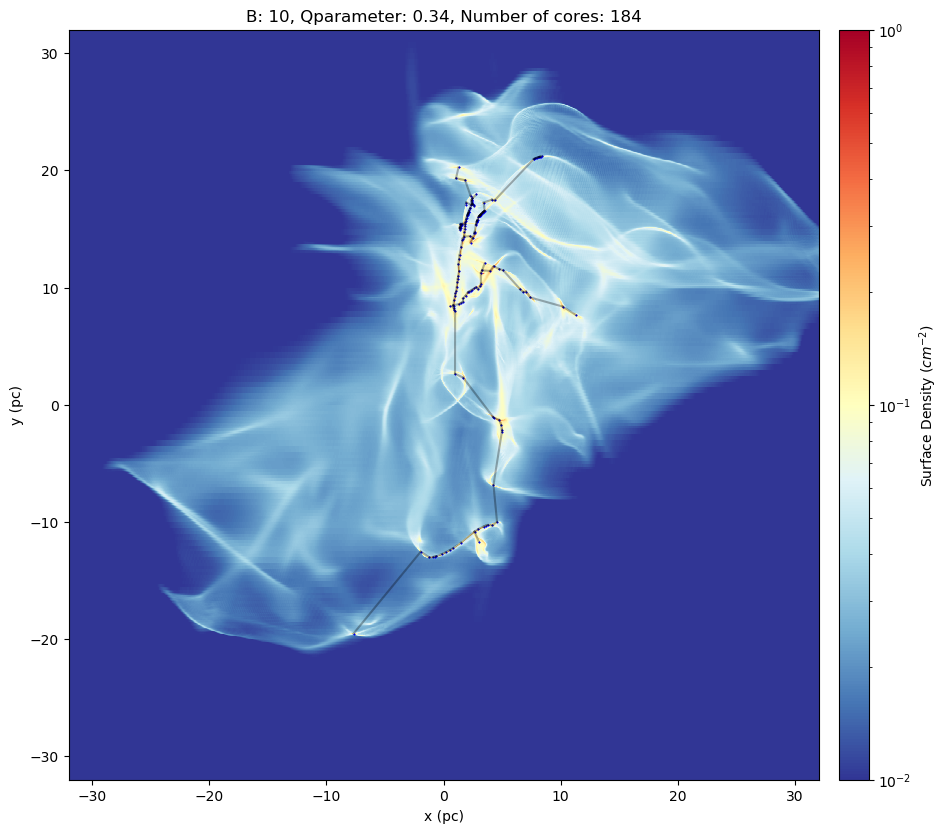

In [28]:
B="10"
fname = "./B{}/offaxis/v10_B10_th60_b05_0024.npy".format(B)
ending=".npy"
data=np.load(fname)
print(np.shape(data))

ulength = ds.length_unit
normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
north = [0, 1, 0]
width = 0.5
center = [0.5, 0.5, 0.5]
resol = 4096

dens=data.T
fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

l = - 0.5 * width * ulength.in_units("pc")
r = + 0.5 * width * ulength.in_units("pc")
b = - 0.5 * width * ulength.in_units("pc")
t = + 0.5 * width * ulength.in_units("pc")

im = ax.imshow(dens,
    norm=LogNorm(vmin=1e-2, vmax=1.0), 
    aspect="equal",
    origin="lower",
    extent=(l,r,b,t),
    cmap="RdYlBu_r"
)
ax.set_xlabel("x (pc)")
ax.set_ylabel("y (pc)")

min_pix_=2.44e-4*(resol**2)/(r*2)**2

dendro = Dendrogram.compute(dens, min_value=0.1, min_delta=0.025, min_npix=min_pix_,verbose=False)

num_cores=len(dendro.leaves)
print("Number of cores: ",num_cores) #Number of "cores"-leaves 
positions=[]

#Get the center position of each core
pixoffset = 0.25 * width * ulength.in_units("pc") / resol
ll = - 0.5 * width * ulength.in_units("pc") - pixoffset
rr = + 0.5 * width * ulength.in_units("pc") - pixoffset
bb = - 0.5 * width * ulength.in_units("pc") - pixoffset
tt = + 0.5 * width * ulength.in_units("pc") - pixoffset

pix2leng = width * ulength.in_units("pc") / resol

for leaf in dendro.leaves:

    stat = PPStatistic(leaf)

    xcoord = (stat.x_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
    ycoord = (stat.y_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
    positions.append([xcoord,ycoord])

    #Scatter the center position
    ax.scatter(xcoord,ycoord,color="blue",marker="*", s=0.2)


#Create matrix of distances between cores for the MST
distances=np.zeros((len(positions),len(positions)))

for i,p1 in enumerate(positions):
    for j,p2 in enumerate(positions):
        if(i!=j):
            distances[i][j]=np.sqrt(np.abs(p1[0]-p2[0])**2+np.abs(p1[1]-p2[1])**2)


#Get MST
Tcsr = minimum_spanning_tree(distances)
mst=Tcsr.toarray()

#Get pairs of cores that are connected
pairs=[]
indx=np.where(mst!=0)
for i in range(len(indx[0])):
    pairs.append([np.array(positions[indx[0][i]]),np.array(positions[indx[1][i]])])

#Plot connection between cores
for pair in pairs:
    pair=np.array(pair)
    plt.plot(pair[:,0],pair[:,1],c="k",alpha=0.3)

# colorbar
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) 
cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
cbar.set_label(r"Surface Density ($cm^{-2}$)")

#Qparameter

#Number of cores
N=len(pairs)+1

#Normalised Correlation Length ¯s
d_cluster=distances.reshape(1,-1)

d_cluster=d_cluster[np.where(d_cluster!=0)]

s=np.mean(d_cluster)

#Normalised Mean Edge Length ¯m
d_mst=np.zeros(N)            

for i,pair in enumerate(pairs):
    d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)

d_mst=d_mst[np.where(d_mst!=0)]
m=np.mean(d_mst)

#Normalize
m1=m/(((N*np.pi)**0.5)/(N-1))

#Calculate Q

Q1=m1/s
print("Q_normalised:",Q1)

#save figure
figname = fname.replace(ending, ".png")
ax.set_title("B: {}, Qparameter: {:.2f}, Number of cores: {}".format(B,Q1,num_cores))
plt.savefig(figname)

### NORMAL

yt : [INFO     ] 2021-06-16 10:54:26,675 Parameters: current_time              = 0.038399984010817 code_time
yt : [INFO     ] 2021-06-16 10:54:26,676 Parameters: domain_dimensions         = [8192 8192    1]
yt : [INFO     ] 2021-06-16 10:54:26,677 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-16 10:54:26,677 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-16 10:54:26,678 Parameters: cosmological_simulation   = 0.0


KeyboardInterrupt: 

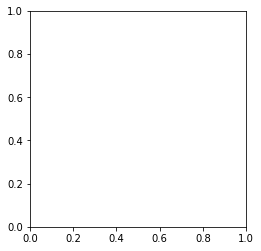

In [3]:
if __name__ == "__main__":
    B="10"
    fname = "./B{}/frb8192/v10_B10_th60_b05_0024_proj_frb.h5".format(B)
    ending=".h5"
    ds = yt.load(fname)
    
    ulength = ds.length_unit
    print(ulength)
    normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
    north = [0, 1, 0]
    width = 0.5
    center = [0.5, 0.5, 0.5]
    resol = 4096

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

    l = - 0.5 * width * ulength.in_units("pc")
    r = + 0.5 * width * ulength.in_units("pc")
    b = - 0.5 * width * ulength.in_units("pc")
    t = + 0.5 * width * ulength.in_units("pc")

    im = ax.imshow(dens,
        norm=LogNorm(vmin=1e-2, vmax=1.0), 
        aspect="equal",
        origin="lower",
        extent=(l,r,b,t),
        cmap="RdYlBu_r"
    )
    ax.set_xlabel("x (pc)")
    ax.set_ylabel("y (pc)")

    #Calculate dendogram
    min_pix_=2.44e-4*(resol**2)/(r*2)**2 #area from pixels to physical coordinates
    dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=min_pix_,verbose=False)

    num_cores=len(dendro.leaves)
    print("Number of cores: ",num_cores) #Number of "cores"-leaves
    positions=[]

    #Get the center position of each core
    pixoffset = 0.25 * width * ulength.in_units("pc") / resol
    ll = - 0.5 * width * ulength.in_units("pc") - pixoffset
    rr = + 0.5 * width * ulength.in_units("pc") - pixoffset
    bb = - 0.5 * width * ulength.in_units("pc") - pixoffset
    tt = + 0.5 * width * ulength.in_units("pc") - pixoffset

    pix2leng = width * ulength.in_units("pc") / resol

    for leaf in dendro.leaves:

        stat = PPStatistic(leaf)

        xcoord = (stat.x_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
        ycoord = (stat.y_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
        if(ycoord<20 and ycoord>-20): #Here we remove "cores" too far from the center
            positions.append([xcoord,ycoord])

            #Scatter the center position
            ax.scatter(xcoord,ycoord,color="blue",marker="*", s=0.2)

    print("Number of efective cores: ",len(positions)) #Number of "cores"-leaves without "cores" too far from the center
    
    #Create matrix of distances between cores for the MST
    distances=np.zeros((len(positions),len(positions)))

    for i,p1 in enumerate(positions):
        for j,p2 in enumerate(positions):
            if(i!=j):
                distances[i][j]=np.sqrt(np.abs(p1[0]-p2[0])**2+np.abs(p1[1]-p2[1])**2)


    #Get MST
    Tcsr = minimum_spanning_tree(distances)
    mst=Tcsr.toarray()

    #Get pairs of cores that are connected
    pairs=[]
    indx=np.where(mst!=0)
    for i in range(len(indx[0])):
        pairs.append([np.array(positions[indx[0][i]]),np.array(positions[indx[1][i]])])

    #Plot connection between cores
    for pair in pairs:
        pair=np.array(pair)
        plt.plot(pair[:,0],pair[:,1],c="k",alpha=0.3)

    # colorbar
    cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) 
    cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
    cbar.set_label(r"Surface Density ($cm^{-2}$)")
    
    #Qparameter

    #Number of cores
    N=len(pairs)+1

    #Normalised Correlation Length ¯s
    d_cluster=distances.reshape(1,-1)

    d_cluster=d_cluster[np.where(d_cluster!=0)]

    s=np.mean(d_cluster)

    #Normalised Mean Edge Length ¯m
    d_mst=np.zeros(N)            

    for i,pair in enumerate(pairs):
        d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)

    d_mst=d_mst[np.where(d_mst!=0)]
    m=np.mean(d_mst)

    #Normalize
    m1=m/(((N*np.pi)**0.5)/(N-1))

    #Calculate Q

    Q1=m1/s
    print("Q_normalised:",Q1)

    #save figure
    figname = fname.replace(ending, ".png")
    ax.set_title("B: {}, Qparameter: {:.2f}, Number of cores: {}".format(B,Q1,num_cores))
    plt.savefig(figname)

In [ ]:
if __name__ == "__main__":
    B="10"
    fname = "./B{}/frb8192/v10_B10_th60_b05_0024_proj_frb.h5".format(B)
    ending=".h5"
    ds = yt.load(fname)
    
    ulength = ds.length_unit
    print(ulength)
    normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
    north = [0, 1, 0]
    width = 0.5
    center = [0.5, 0.5, 0.5]
    resol = 4096

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
    fig, ax = plt.subplots()
    fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

    l = - 0.5 * width * ulength.in_units("pc")
    r = + 0.5 * width * ulength.in_units("pc")
    b = - 0.5 * width * ulength.in_units("pc")
    t = + 0.5 * width * ulength.in_units("pc")

    im = ax.imshow(dens,
        norm=LogNorm(vmin=1e-2, vmax=1.0), 
        aspect="equal",
        origin="lower",
        extent=(l,r,b,t),
        cmap="RdYlBu_r"
    )
    ax.set_xlabel("x (pc)")
    ax.set_ylabel("y (pc)")
    
    # colorbar
    cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) 
    cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
    cbar.set_label(r"Surface Density ($cm^{-2}$)")
    
    #Calculate dendogram
    min_pix_=2.44e-4*(resol**2)/(r*2)**2 #area from pixels to physical coordinates
    dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=min_pix_,verbose=True)


yt : [INFO     ] 2021-06-16 11:11:08,653 Parameters: current_time              = 0.038399984004365 code_time
yt : [INFO     ] 2021-06-16 11:11:08,654 Parameters: domain_dimensions         = [8192 8192    1]
yt : [INFO     ] 2021-06-16 11:11:08,654 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-16 11:11:08,655 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-16 11:11:08,656 Parameters: cosmological_simulation   = 0.0


3.95e+20 cm
Generating dendrogram using 82,431 of 67,108,864 pixels (0.12283176183700562% of data)

[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 0%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 1%
[>                                        ] 2%
[>                                        ] 2%
[>                                        ] 2%
[>     

[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 20%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 21%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[========>                                ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 22%
[=========>                               ] 23%
[=========>                             

[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 41%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[================>                        ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 42%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                       ] 43%
[=================>                     

[========================>                ] 61%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[========================>                ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 62%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 63%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>               ] 64%
[=========================>             

[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 82%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 83%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[=================================>       ] 84%
[==================================>    

## Q parameter

In [7]:
#Qparameter

#Number of cores
N=len(pairs)+1

#Normalised Correlation Length ¯s
d_cluster=distances.reshape(1,-1)

d_cluster=d_cluster[np.where(d_cluster!=0)]

s=np.mean(d_cluster)

#Normalised Mean Edge Length ¯m
d_mst=np.zeros(N)            
            
for i,pair in enumerate(pairs):
    d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)
                    
d_mst=d_mst[np.where(d_mst!=0)]
m=np.mean(d_mst)

#Normalize
m1=m/(((N*np.pi)**0.5)/(N-1))

#Calculate Q
Q=m/s

Q1=m1/s
print("m:",m,", m_normalised:",m1,", s:",s,", Q:",Q,", Q_normalised:",Q1)

m: 1.1109426082592575 , m_normalised: 5.392264098265508 , s: 6.575658613167985 , Q: 0.16894773187199172 , Q_normalised: 0.8200340704225904


In [ ]:
def Qparameter(distances,pairs):

    #Number of cores
    N=len(pairs)+1

    #Normalised Correlation Length ¯s
    d_cluster=distances.reshape(1,-1)

    d_cluster=d_cluster[np.where(d_cluster!=0)]

    s=np.mean(d_cluster)

    #Normalised Mean Edge Length ¯m
    d_mst=np.zeros(N)            

    for i,pair in enumerate(pairs):
        d_mst[i]=np.sqrt(np.abs(pair[0][0]-pair[1][0])**2+np.abs(pair[0][1]-pair[1][1])**2)

    d_mst=d_mst[np.where(d_mst!=0)]
    m=np.mean(d_mst)

    #Normalize
    m1=m/(((N*np.pi)**0.5)/(N-1))

    #Calculate Q
    Q=m/s

    Q1=m1/s
    
    return Q1

## Histograms 

### Edges by core 

Counter({2: 158, 1: 14, 3: 12})


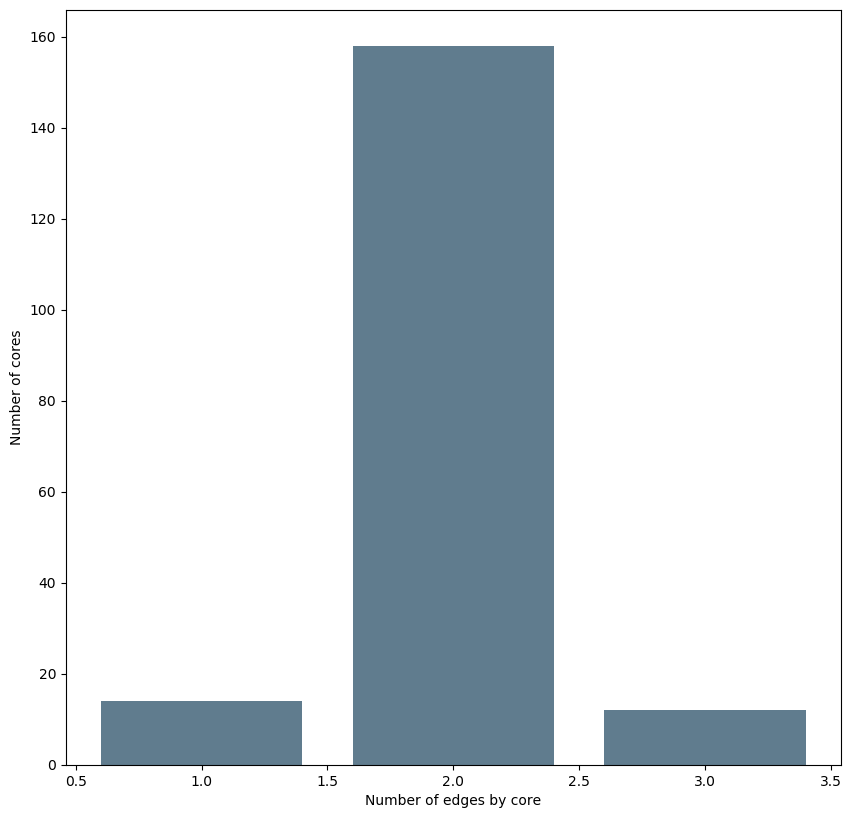

In [18]:
c_edges=collections.Counter()

counter={}

for pair in pairs:
    for i in range(2):
        try:
            counter[str(pair[i][0])+","+str(pair[i][1])]+=1
        except:
            counter[str(pair[i][0])+","+str(pair[i][1])]=1
            
num_edges=counter.values()
c_edges.update(num_edges)

coresw2edges=np.array([np.array(k.split(",")).astype(np.float) for k,v in counter.items() if v == 2])

plt.bar(c_edges.keys(),c_edges.values(),color='#607c8e')
plt.xlabel("Number of edges by core")
plt.ylabel("Number of cores")
#plt.hist(num_edges)
print(c_edges)

#save figure
figname = fname.replace(ending, "_hist_ebc.png")
plt.savefig(figname)

### Distances of MST

168


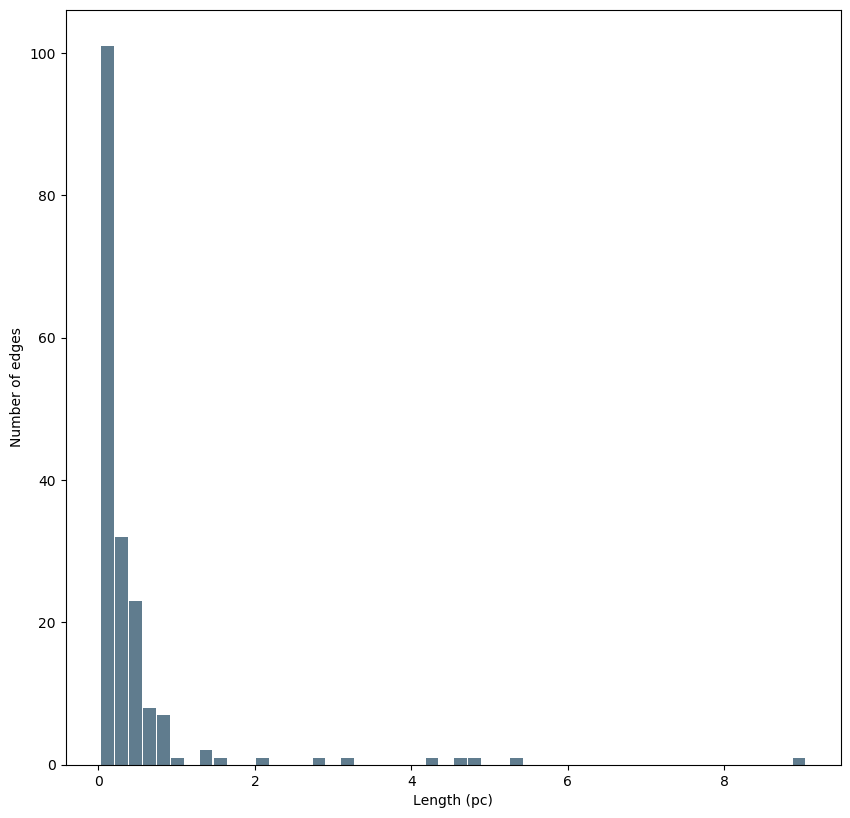

In [19]:
c_distances=collections.Counter(d_mst)
print(len(list(c_distances.keys())))

plt.hist(d_mst,rwidth=0.9,color='#607c8e',bins=50)
plt.xlabel("Length (pc)")
plt.ylabel("Number of edges")

#save figure
figname = fname.replace(ending, "_hist_dMST.png")
plt.savefig(figname)

[[0.02209895 5.        ]
 [0.02209895 4.        ]
 [0.02209895 9.        ]]


<BarContainer object of 3 artists>

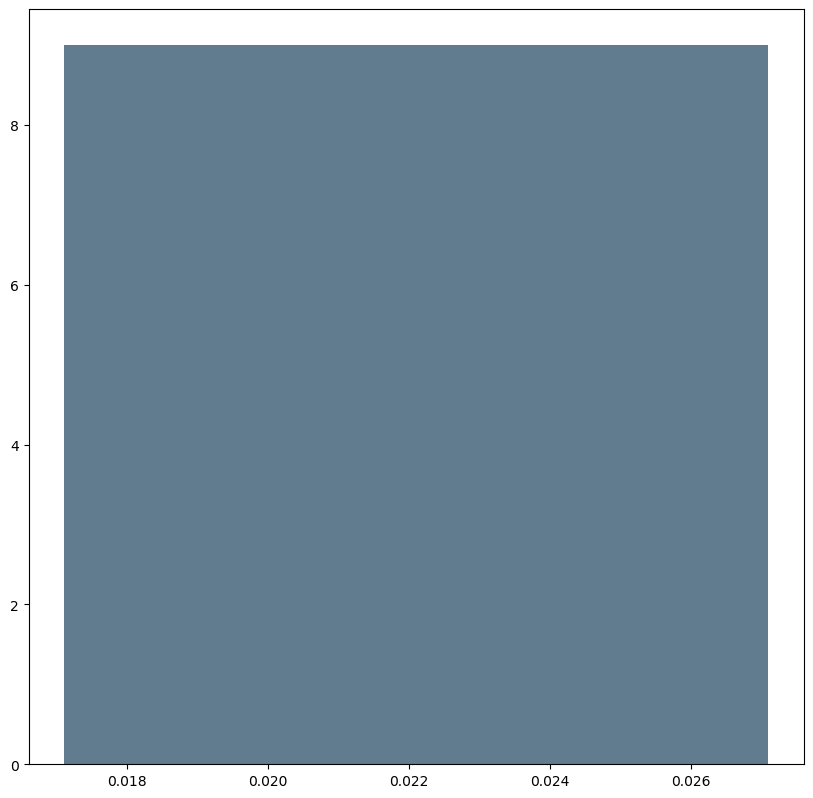

In [20]:
#f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=False)
dist=np.array([[k,v] for k,v in c_distances.items() if v >= 2])
print(dist)
plt.bar(dist[:,0],dist[:,1],width=0.01,color='#607c8e')

### Angles from cores with 2 edges

In [21]:
pairsw2edges=[]
for corew2edges in coresw2edges:
    pair_=[]
    for pair in pairs:
        if(corew2edges==pair[0]).all() or (corew2edges==pair[1]).all():
            pair_.append(pair)
            
    pairsw2edges.append(np.array(pair_))
    if(len(pair_)>2):
        print(corew2edges)
        print(pair_)
print(len(pairsw2edges)) 
print(pairsw2edges[0]) 

158
[[[ -7.68301231 -19.53245718]
  [ -1.94400846 -12.54168012]]

 [[ -1.94400846 -12.54168012]
  [ -1.20681534 -13.01859192]]]


158
158
[[[ -7.68301231 -19.53245718]
  [ -1.94400846 -12.54168012]]

 [[ -1.94400846 -12.54168012]
  [ -1.20681534 -13.01859192]]]


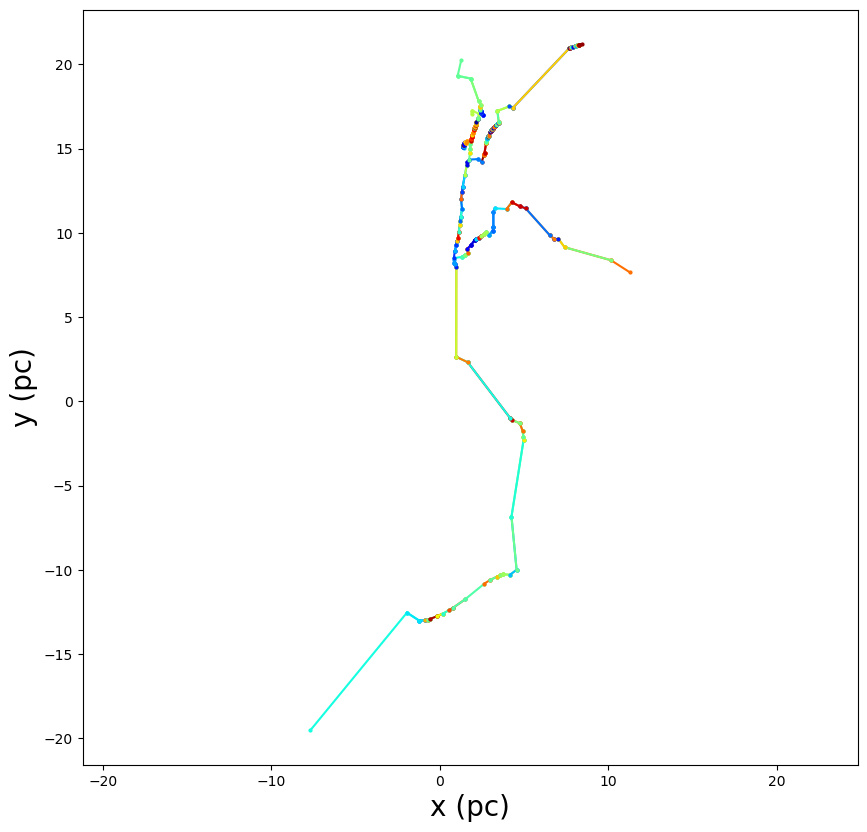

In [22]:
print(len(coresw2edges))

#pairsw2edges=[[pairs[np.where(pairs==corew2edges)[0][0]],pairs[np.where(pairs==corew2edges)[0][2]]] for corew2edges in coresw2edges]

print(len(pairsw2edges))

print(pairsw2edges[0])

colors = plt.cm.jet(np.linspace(0,1,len(pairsw2edges)))

for pairs2 in pairsw2edges:
    cc=np.random.randint(0,len(pairsw2edges))
    for pair in pairs2:
        plt.plot(pair[:,0],pair[:,1],'o-',c=colors[cc],markersize=2)
plt.axis("equal")
plt.xlabel("x (pc)",fontsize=20)
plt.ylabel("y (pc)",fontsize=20)

#save figure
figname = fname.replace(ending, "_MSTw2edges.png")
plt.savefig(figname)

In [13]:
def angle(d_b,d_c,d_a):
    return np.rad2deg(np.arccos(((d_b**2)+(d_c**2)-(d_a**2))/(2*d_b*d_c)))

def length(x1,y1,x2,y2):
    return np.sqrt(((x1-x2)**2)+((y1-y2)**2))

num_2edges=130
d_pp=[length(*ppi[0],*ppi[1]) for ppi in pairsw2edges[num_2edges]]
for ppi in pairsw2edges[num_2edges][0]:
    for ppi2 in pairsw2edges[num_2edges][1]:
        l=length(*ppi,*ppi2)
        if (ppi!=ppi2).all() and l not in d_pp:
            d_pp.append(l)

for pair in pairsw2edges[num_2edges]:
    cc=np.random.randint(0,len(pairsw2edges))
    plt.plot(np.array(pair)[:,0],np.array(pair)[:,1],'o-',c=colors[cc])


A=angle(*d_pp)
B=angle(d_pp[0],d_pp[2],d_pp[1])
C=angle(d_pp[1],d_pp[2],d_pp[0])
print("A",A)
print("Other",B)
print("Other",C)
print("sum",A+B+C)
plt.axis("equal")
plt.xlabel("x (pc)")
plt.ylabel("y (pc)")

IndexError: list index out of range

In [23]:
def angle(d_b,d_c,d_a):
    return np.rad2deg(np.arccos(((d_b**2)+(d_c**2)-(d_a**2))/(2*d_b*d_c)))

def length(x1,y1,x2,y2):
    return np.sqrt(((x1-x2)**2)+((y1-y2)**2))

angles=[]
for pairw2edges in pairsw2edges:
    d_pp=[]
    p_pp={}
    for ppi in pairw2edges:
        p_pp[str(ppi[0])+","+str(ppi[1])]=0
        p_pp[str(ppi[1])+","+str(ppi[0])]=0
        d_pp.append(length(*ppi[0],*ppi[1]))
        
    for ppi in pairw2edges[0]:
        for ppi2 in pairw2edges[1]:
            l=length(*ppi,*ppi2)
            if l!=0:
                if p_pp.get(str(ppi)+","+str(ppi2))==None:
                    p_pp[str(ppi)+","+str(ppi2)]=0
                    p_pp[str(ppi2)+","+str(ppi)]=0
                    d_pp.append(l)

    A=angle(*d_pp)
    angles.append(A)
    
    """try:
        A=angle(*d_pp)
        angles.append(A)
        B=angle(d_pp[0],d_pp[2],d_pp[1])
        C=angle(d_pp[1],d_pp[2],d_pp[0])
    except:
        cc=np.random.randint(0,len(pairsw2edges))
        print(pairw2edges)
        #print(length(*pairw2edges[0][1],*pairw2edges[0][0]))
        print(d_pp)
        for pair in pairw2edges:
        plt.plot(np.array(pair)[:,0],np.array(pair)[:,1],'o-',c=colors[cc],markersize=1.5)
        plt.axis("equal")
        """
    #print("A",A)
    """print("Otro",B)
    print("Otro",C)
    print("sum",A+B+C)"""

/home/valentina/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in arccos
  


158


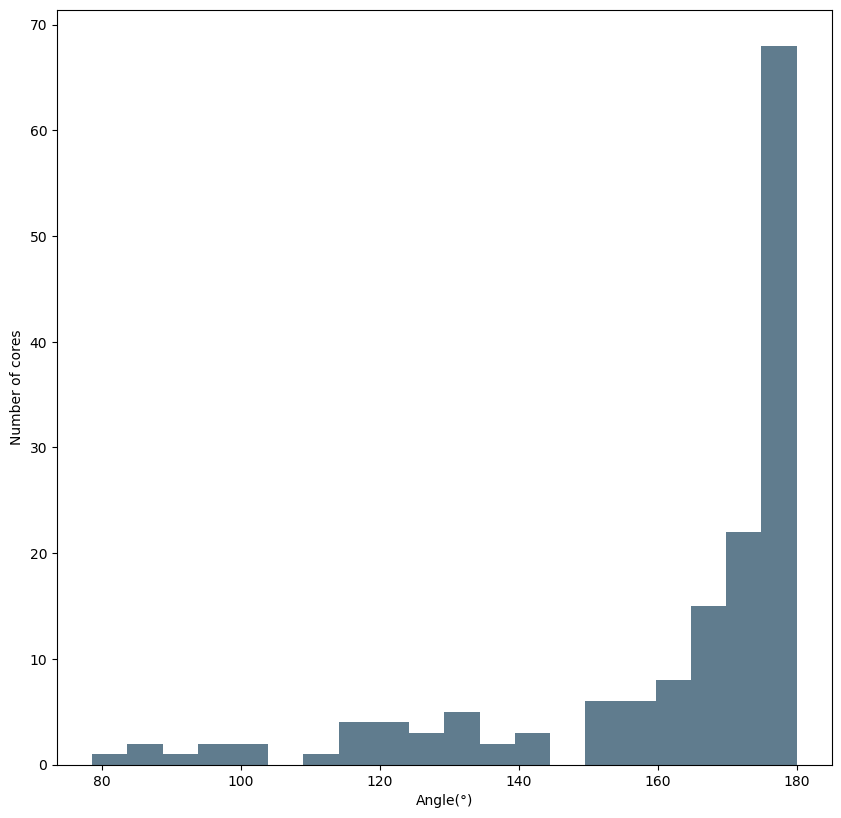

In [24]:
print(len(angles))
plt.hist(angles,bins=20,color='#607c8e')
plt.xlabel("Angle(°)")
plt.ylabel("Number of cores")#That join the two edges

#save figure
figname = fname.replace(ending, "_hist_anglesMSTw2edges.png")
plt.savefig(figname)

## Dendro contours 

yt : [INFO     ] 2021-06-10 18:36:09,022 Parameters: current_time              = 0.043199984103449 code_time
yt : [INFO     ] 2021-06-10 18:36:09,022 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-06-10 18:36:09,023 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-10 18:36:09,024 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-10 18:36:09,024 Parameters: cosmological_simulation   = 0.0


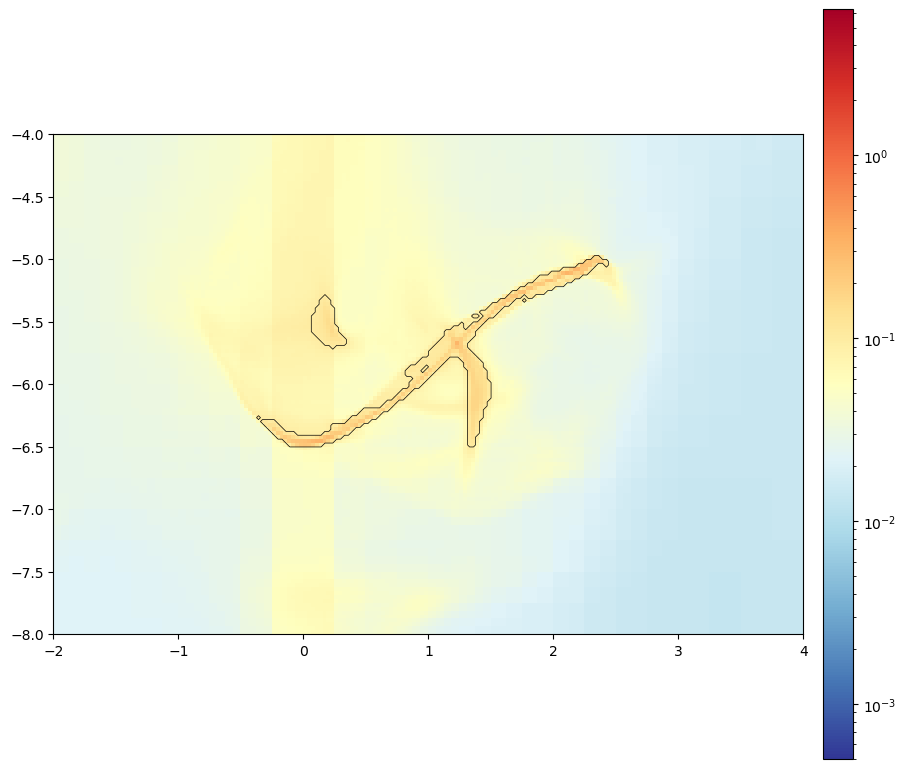

In [121]:
if __name__ == "__main__":
    fname = "./frb2048/v10_B10_th60_b05_0027_proj_frb.h5"
    ds = yt.load(fname)

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=0.062,verbose=False)
dp = dendro.plotter()

fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)
im = ax.imshow(dens, norm=LogNorm(vmin=vmin, vmax=vmax), aspect='equal', origin='lower', extent=(l,r,b,t),interpolation='nearest',cmap='RdYlBu_r')

# Show contour for ``min_value``
dp.plot_contour(ax, color='black', extent=(l,r,b,t),linewidths=0.5)

stat = PPStatistic(dendro[8])
ax.set_xlim(-2,4)
ax.set_ylim(-8,-4)

# colorbar
cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) 
cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
#plt.savefig("dendogram.png")

yt : [INFO     ] 2021-06-10 17:55:55,072 Parameters: current_time              = 0.047999984165473 code_time
yt : [INFO     ] 2021-06-10 17:55:55,073 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-06-10 17:55:55,073 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-10 17:55:55,074 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-10 17:55:55,075 Parameters: cosmological_simulation   = 0.0


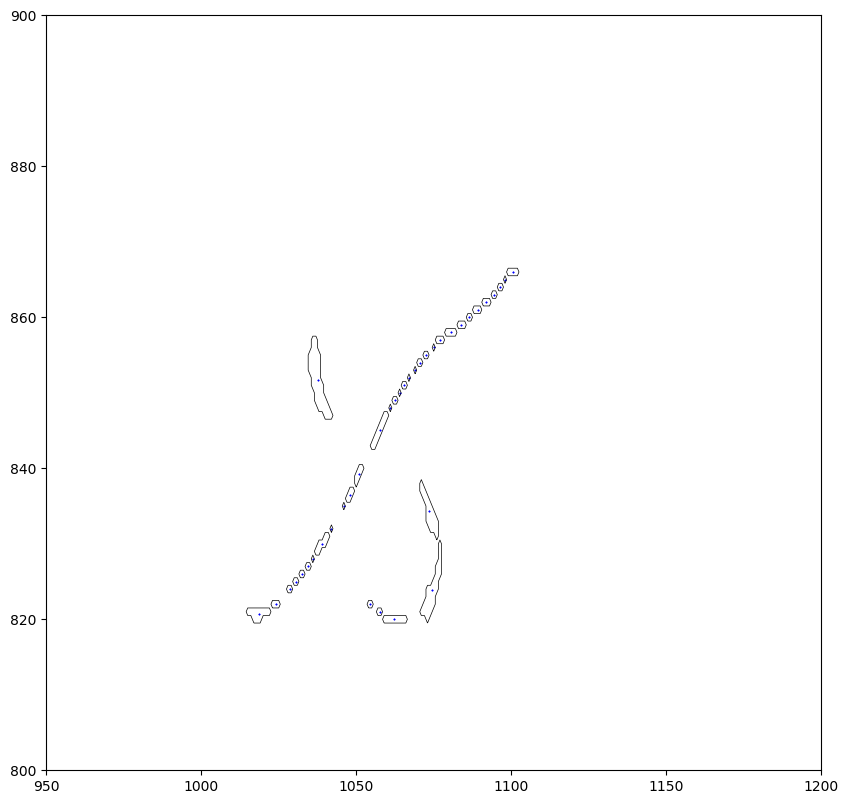

In [96]:
#Pixels
fig, ax = plt.subplots()

if __name__ == "__main__":
    fname = "./frb2048/v10_B10_th60_b05_0030_proj_frb.h5"
    ds = yt.load(fname)

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=0.062,verbose=False)
#p = d.plotter()

for leaf in dendro.leaves:
    
    stat = PPStatistic(leaf)
    
    ax.scatter((stat.x_cen.value),(stat.y_cen.value),color="blue",marker="*", s=0.2)

    dp.plot_contour(ax, structure=leaf, lw=3,colors='black',linewidths=0.5)

    ax.set_xlim(950,1200)
    ax.set_ylim(800,900)

(-8, -4)

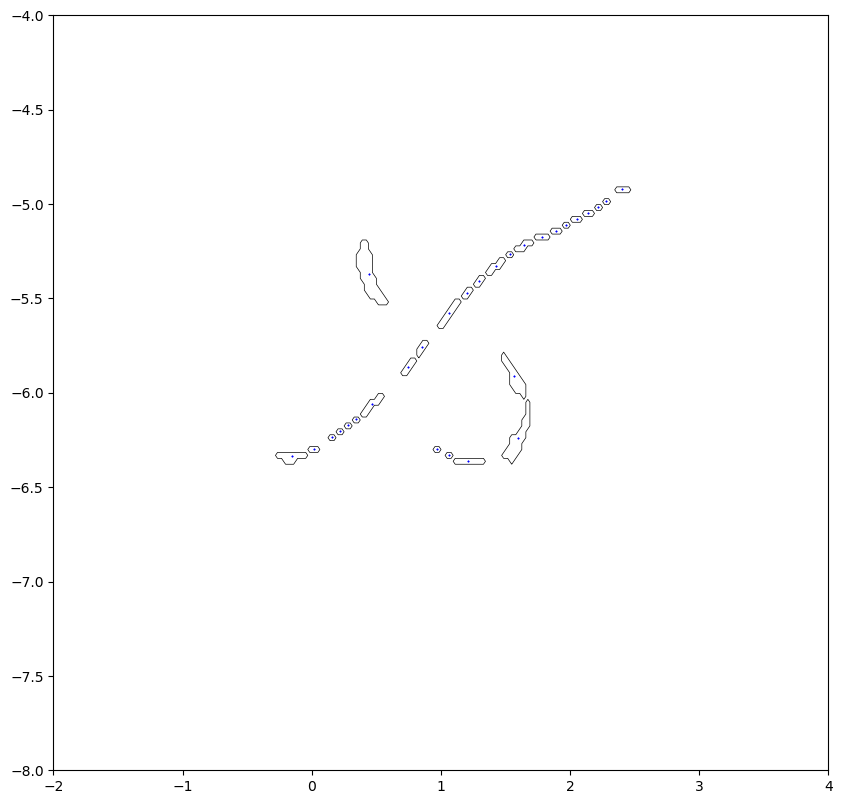

In [100]:
#Coordinates
fig, ax = plt.subplots()

pixoffset = 0.25 * width * ulength.in_units("pc") / resol
ll = - 0.5 * width * ulength.in_units("pc") - pixoffset
rr = + 0.5 * width * ulength.in_units("pc") - pixoffset
bb = - 0.5 * width * ulength.in_units("pc") - pixoffset
tt = + 0.5 * width * ulength.in_units("pc") - pixoffset

pix2leng = width * ulength.in_units("pc") / resol

for leaf in dendro.leaves:
    
    stat = PPStatistic(leaf)
    
    xcoord = (stat.x_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
    ycoord = (stat.y_cen.value+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
    #positions.append([xcoord,ycoord])
    
    ax.scatter(xcoord,ycoord,color="blue",marker="*", s=0.2)

    dp.plot_contour(ax, structure=leaf, lw=3, colors='black',extent=(l,r,b,t),linewidths=0.5)

ax.set_xlim(-2,4)
ax.set_ylim(-8,-4)

yt : [INFO     ] 2021-06-10 18:03:44,902 Parameters: current_time              = 0.047999984165473 code_time
yt : [INFO     ] 2021-06-10 18:03:44,903 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-06-10 18:03:44,903 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-06-10 18:03:44,904 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-06-10 18:03:44,905 Parameters: cosmological_simulation   = 0.0


(-8, -4)

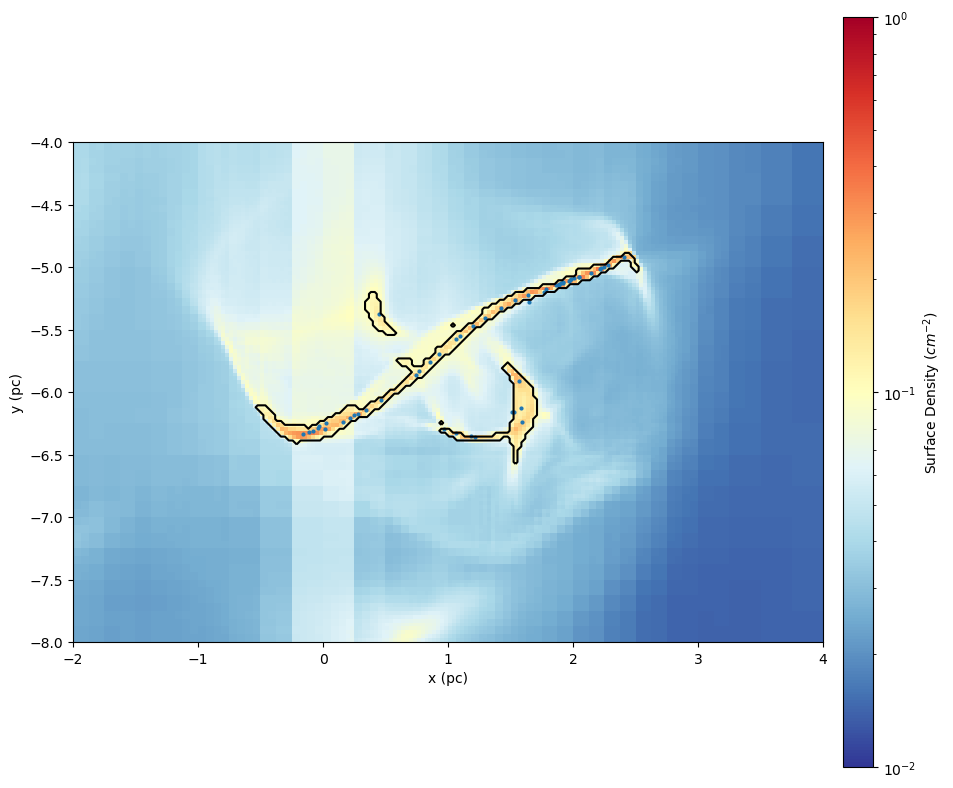

In [97]:
fname = "./frb2048/v10_B10_th60_b05_0030_proj_frb.h5"
ds = yt.load(fname)
ulength = ds.length_unit
normal = [0.2679491, 0, 1.0] # vector normal to cutting plane
north = [0, 1, 0]
width = 0.5
center = [0.5, 0.5, 0.5]
resol = 2048
#dens = yt.off_axis_projection(ds, center, normal, width, resol, "density", north_vector=north).to_ndarray()
data=ds.all_data()["density"]
num=int(np.sqrt(np.shape(data)[0]))

# get density field and convert back to 2-d array
dens = data.reshape(num,-1)

dendro = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=2)
dp = dendro.plotter()

fig, ax = plt.subplots()
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.85, top=0.85, hspace=0.0, wspace=0.0)

l = - 0.5 * width * ulength.in_units("pc")
r = + 0.5 * width * ulength.in_units("pc")
b = - 0.5 * width * ulength.in_units("pc")
t = + 0.5 * width * ulength.in_units("pc")

im = ax.imshow(dens,
    norm=LogNorm(vmin=1e-2, vmax=1.0), 
    aspect="equal",
    origin="lower",
    extent=(l,r,b,t),
    cmap="RdYlBu_r"
)

ax.set_xlabel("x (pc)")
ax.set_ylabel("y (pc)")

cbar_ax = fig.add_axes([0.87, 0.1, 0.03, 0.75]) #this place the axis
cbar = plt.colorbar(im, orientation="vertical", cax=cbar_ax)
cbar.set_label(r"Surface Density ($cm^{-2}$)")

pixoffset = 0.25 * width * ulength.in_units("pc") / resol
ll = - 0.5 * width * ulength.in_units("pc") - pixoffset
rr = + 0.5 * width * ulength.in_units("pc") - pixoffset
bb = - 0.5 * width * ulength.in_units("pc") - pixoffset
tt = + 0.5 * width * ulength.in_units("pc") - pixoffset

# dp.plot_contour(ax, color='black', extent=(l,r,b,t))
dp.plot_contour(ax, color='black', extent=(ll,rr,bb,tt))

xcoord = np.array([PPStatistic(s).x_cen.value for s in dendro.all_structures])
ycoord = np.array([PPStatistic(s).y_cen.value for s in dendro.all_structures])

pix2leng = width * ulength.in_units("pc") / resol
xcoord = (xcoord+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")
ycoord = (ycoord+0.5) * pix2leng - 0.5 * width * ulength.in_units("pc")

ax.scatter(xcoord, ycoord, s=4)
ax.set_xlim(-2,4)
ax.set_ylim(-8,-4)

17.195682604966567


2.0117820339623833

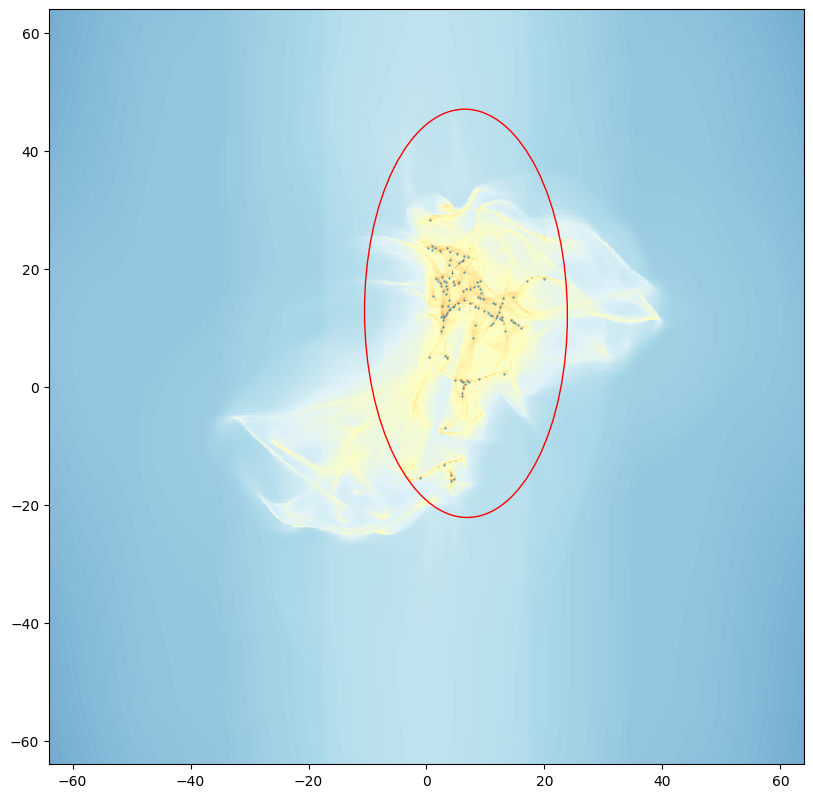

In [38]:
#Q parameter

from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

def confidence_ellipse(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of *x* and *y*.

    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`

    Returns
    -------
    matplotlib.patches.Ellipse
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    e=ellipse.set_transform(transf + ax.transData)
    ax.add_patch(ellipse)
    print(scale_x)
    return ellipse


fig, ax = plt.subplots()

ax.imshow(dens, norm=LogNorm(vmin=vmin, vmax=vmax), aspect='equal', origin='lower', extent=(l,r,b,t),interpolation='nearest',cmap='RdYlBu_r')
positions=np.array(positions)
ax.scatter(positions[:,0],positions[:,1],s=0.2)
ellipse=confidence_ellipse(positions[:,0], positions[:,1], ax,n_std=4, edgecolor='red')

ellipse.height

yt : [INFO     ] 2021-05-26 08:41:26,841 Parameters: current_time              = 0.043199984372252 code_time
yt : [INFO     ] 2021-05-26 08:41:26,842 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-05-26 08:41:26,843 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-05-26 08:41:26,844 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-05-26 08:41:26,845 Parameters: cosmological_simulation   = 0.0


[('grid', 'density')]
-64.0053909775 64.0053909775 -64.0053909775 64.0053909775


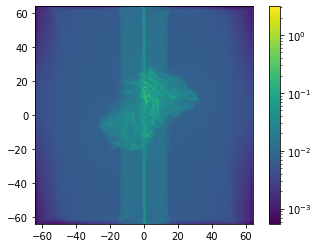

In [2]:
if __name__ == "__main__":
    fname = "./frb2048/v10_B10_th60_b05_0027_proj_frb.h5"
    ds = yt.load(fname)

    # list all field
    print(ds.field_list)
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)

    # using yt to plot
    """p = yt.ProjectionPlot(ds, "z", "density")
    p.save()"""

    # another way to plot
    left = (ds.domain_left_edge - ds.domain_center).in_units('pc').value
    right = (ds.domain_right_edge - ds.domain_center).in_units('pc').value
    # 2-dim image, axes are "x" (index=0), "y" (index=1)
    # l: left, r: right, b: bottom, t: top
    l = left[0]
    r = right[0]
    b = left[1]
    t = right[1]
    vmin = dens.min()
    vmax = dens.max()
    print(l,r,b,t)

    # create figure
    fig, ax = plt.subplots()

    # plot 2-d array
    im = ax.imshow(dens, norm=LogNorm(vmin=vmin, vmax=vmax),
                   aspect='equal',
                   origin='lower',
                   extent=(l,r,b,t),
                   )

    # colorbar
    cbar = plt.colorbar(im, orientation="vertical")

    #save figure
    figname = fname.replace(".h5", ".png")
    #plt.savefig(figname)

yt : [INFO     ] 2021-05-16 10:54:56,439 Parameters: current_time              = 0.043199984372252 code_time
yt : [INFO     ] 2021-05-16 10:54:56,440 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-05-16 10:54:56,440 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-05-16 10:54:56,441 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-05-16 10:54:56,441 Parameters: cosmological_simulation   = 0.0


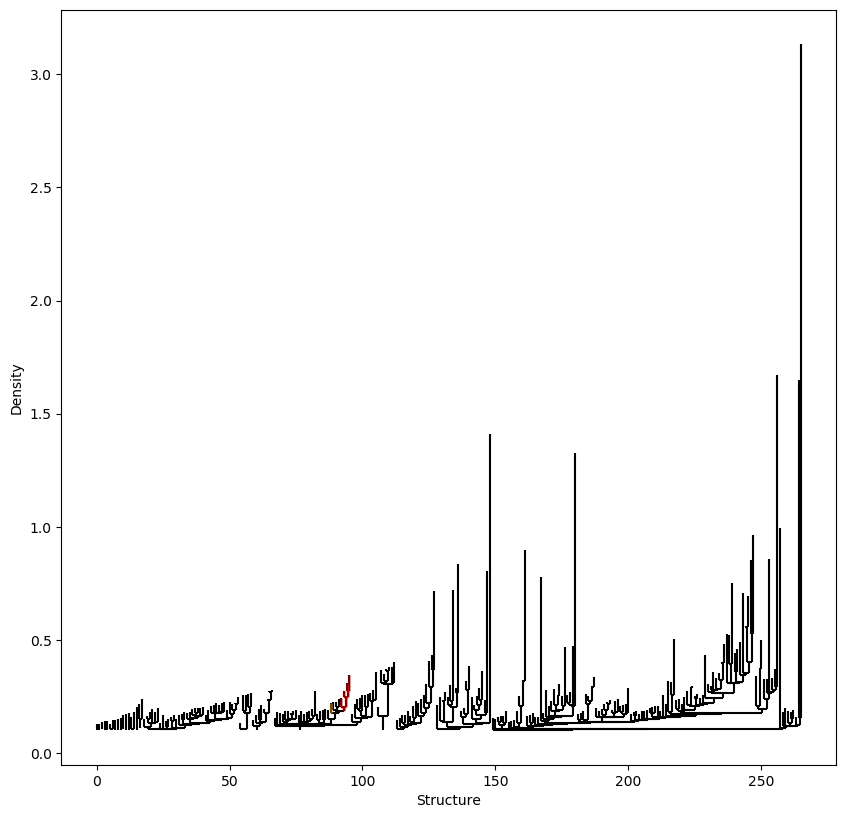

In [18]:
if __name__ == "__main__":
    fname = "./frb2048/v10_B10_th60_b05_0027_proj_frb.h5"
    ds = yt.load(fname)

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
d = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=0.062,verbose=False)
p = d.plotter()

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

# Plot the whole tree
p.plot_tree(ax, color='black')

# Highlight two branches
p.plot_tree(ax, structure=8, color='red', lw=2, alpha=0.5)
p.plot_tree(ax, structure=24, color='orange', lw=2, alpha=0.5)

# Add axis labels
ax.set_xlabel("Structure")
ax.set_ylabel("Density")#--not sure
plt.show()

In [5]:
distances=np.zeros((len(positions),len(positions)))

for i,p1 in enumerate(positions):
    for j,p2 in enumerate(positions):
        if(i!=j):
            distances[i][j]=np.sqrt(np.abs(p1[0]-p2[0])**2+np.abs(p1[1]-p2[1])**2)
            
np.savetxt("prueba.txt",distances)
print(distances)

[[  0.          34.82586709 126.69468663 ... 663.9126645  665.53010102
  701.0446325 ]
 [ 34.82586709   0.         125.75659616 ... 647.46245473 649.14002863
  681.47952919]
 [126.69468663 125.75659616   0.         ... 546.63882857 548.14636594
  589.69033886]
 ...
 [663.9126645  647.46245473 546.63882857 ...   0.           2.0899929
   78.86348633]
 [665.53010102 649.14002863 548.14636594 ...   2.0899929    0.
   79.40294281]
 [701.0446325  681.47952919 589.69033886 ...  78.86348633  79.40294281
    0.        ]]


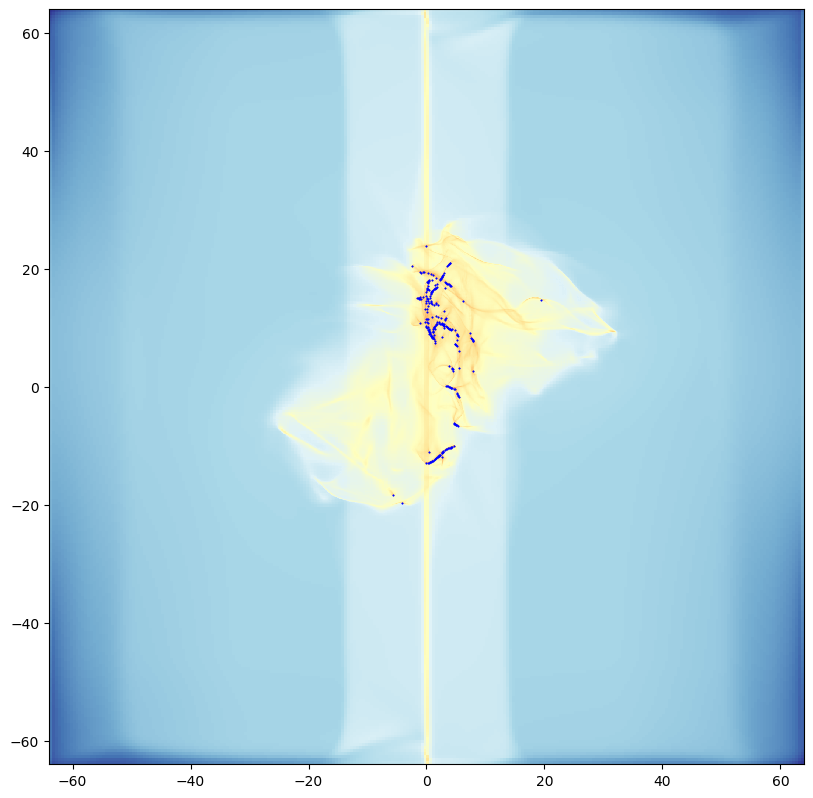

In [50]:
fig, ax = plt.subplots()
im = ax.imshow(dens, norm=LogNorm(vmin=vmin, vmax=vmax), aspect='equal', origin='lower',extent=(l,r,b,t),interpolation='nearest',cmap='RdYlBu_r')
for leaf in d.leaves:
    
    stat = PPStatistic(leaf)
    
    ax.scatter((stat.x_cen.value*(64.0053909775)/1024)-64.0053909775,(stat.y_cen.value*(64.0053909775)/1024)-64.0053909775,color="blue",marker="*", s=0.2)

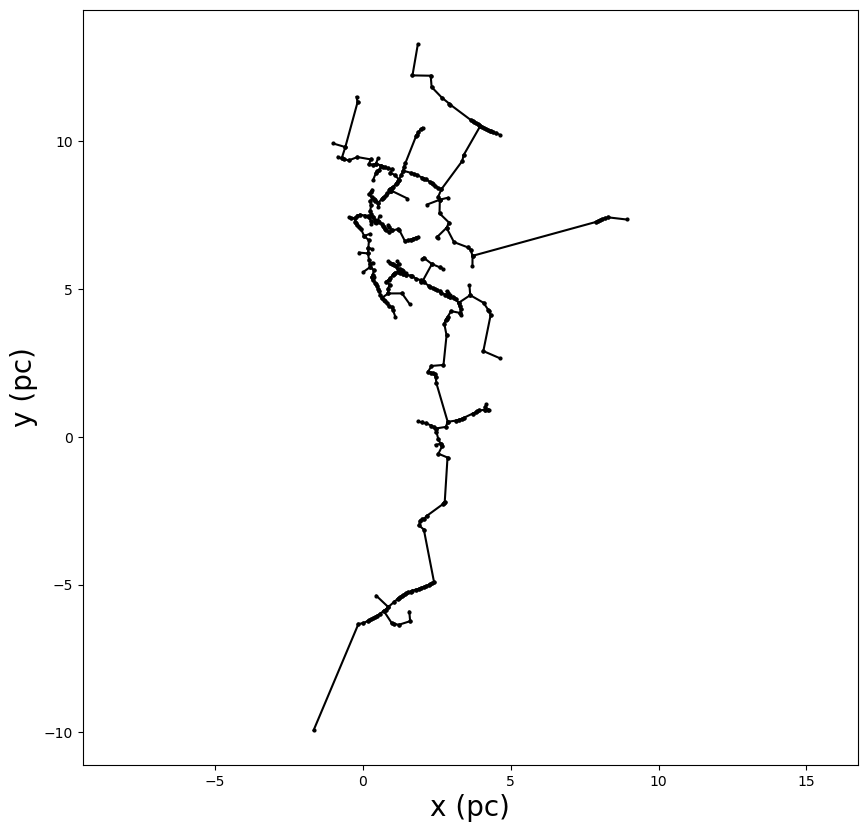

In [37]:
"""pairs=[]
indx=np.where(mst!=0)
for i in range(len(indx[0])):
    pairs.append([np.array(positions[indx[0][i]]),np.array(positions[indx[1][i]])])
    
for pair in pairs:
    pair=np.array(pair)
    plt.plot(pair[:,0],pair[:,1],'o-',c="k",markersize=3)"""

#Plot connection between cores
for pair in pairs:
    pair=np.array(pair)
    plt.plot(pair[:,0],pair[:,1],'o-',c="k",markersize=2)
    
plt.axis("equal")
plt.xlabel("x (pc)",fontsize=20)
plt.ylabel("y (pc)",fontsize=20)

#save figure
figname = fname.replace(".h5", "_MST.png")
plt.savefig(figname)

## Ignore 

In [2]:
""" Otra forma de leer
import h5py
fname = "./frb2048/v10_B10_th60_b05_0028_proj_frb.h5"
filename = fname

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])
    print(data)
    x=f[a_group_key]['density'][()]
    print(np.shape(x))"""

Keys: <KeysViewHDF5 ['grid']>
['density']
(8192, 8192)


In [3]:
print(np.shape(ds.all_data()["density"]))
print(np.shape(ds.all_data()["z"]))
print(ds.all_data()["density"])
ds.all_data()["z"]

(4194304,)
(4194304,)
[0.00293802 0.00293802 0.00293802 ... 0.00292181 0.00292181 0.00292181] g/cm**2


YTArray([1.975e+20, 1.975e+20, 1.975e+20, ..., 1.975e+20, 1.975e+20,
         1.975e+20]) cm

In [151]:
print(np.shape(ds.all_data()["density"]))
print(np.shape(ds.all_data()["z"]))
print(ds.all_data()["density"])
ds.all_data()["z"]
print(vmin,vmax)

(65536,)
(76448,)
[0.00768512 0.00768512 0.00768512 ... 0.00768512 0.00768512 0.00768512] g/cm**2
0.007685120000000045 g/cm**2 0.029299519999999954 g/cm**2


(313, 217)
WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): (313, 217)

Pixel Dim  Data size  Bounds
        0        217  None
        1        313  None

World Dim  Physical Type     Units
        0  pos.galactic.lon  deg
        1  pos.galactic.lat  deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


/home/valentina/anaconda3/lib/python3.7/site-packages/astrodendro/viewer.py:95: UserWarning: `WCSAxes` package required for wcs coordinate display.
  warnings.warn("`WCSAxes` package required for wcs coordinate display.")


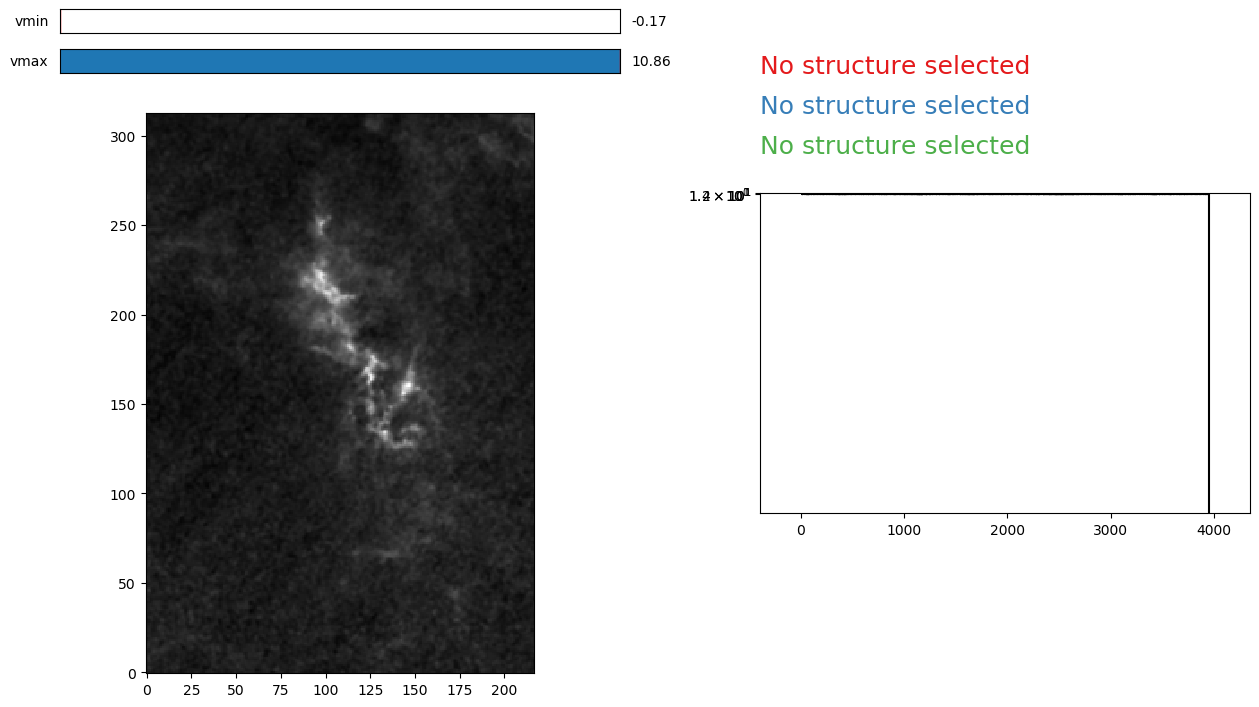

In [79]:
#%matplotlib notebook
from astropy.io.fits import getdata
from astropy.io import fits
from astropy import wcs
image,header = fits.getdata('PerA_Extn2MASS_F_Gal.fits',header=True)
print(image.shape)
print(header)
#d = Dendrogram.compute(image, min_value=2.0, min_delta=1., min_npix=10,verbose=True)
wcs = wcs.WCS(header)
print(wcs)
d = Dendrogram.compute(image, wcs=wcs)
v = d.viewer()
v.show()

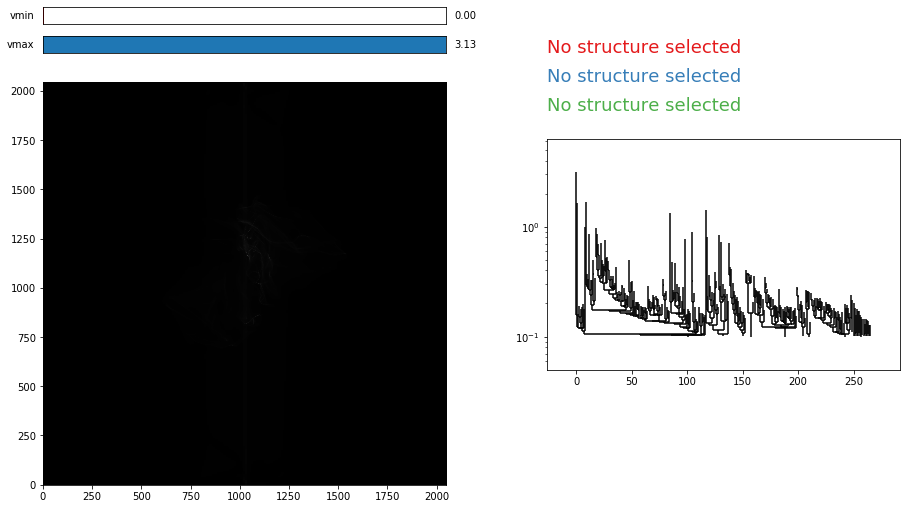

In [100]:
v = d.viewer()
v.show()

In [59]:
structure = d[8]
mask_08=structure.get_mask()
x=mask_08.astype('short')
print(np.where(x==1))

stat = PPStatistic(structure)
print(stat.y_cen.value)
stat.y_cen

(array([816, 816, 816, 816, 816, 817, 817, 817, 817, 817, 817, 817, 817,
       817, 817, 817, 818, 818, 818, 819, 819, 819]), array([1022, 1023, 1024, 1025, 1026, 1020, 1021, 1022, 1023, 1024, 1025,
       1026, 1027, 1028, 1029, 1030, 1029, 1030, 1031, 1031, 1032, 1033]))
817.1718101572926


<Quantity 817.17181016 pix>

In [54]:
d.trunk[8]

<Structure type=branch idx=127>

yt : [INFO     ] 2021-05-16 10:56:07,054 Parameters: current_time              = 0.043199984372252 code_time
yt : [INFO     ] 2021-05-16 10:56:07,054 Parameters: domain_dimensions         = [2048 2048    1]
yt : [INFO     ] 2021-05-16 10:56:07,055 Parameters: domain_left_edge          = [0. 0. 0.] code_length
yt : [INFO     ] 2021-05-16 10:56:07,055 Parameters: domain_right_edge         = [1. 1. 1.] code_length
yt : [INFO     ] 2021-05-16 10:56:07,056 Parameters: cosmological_simulation   = 0.0


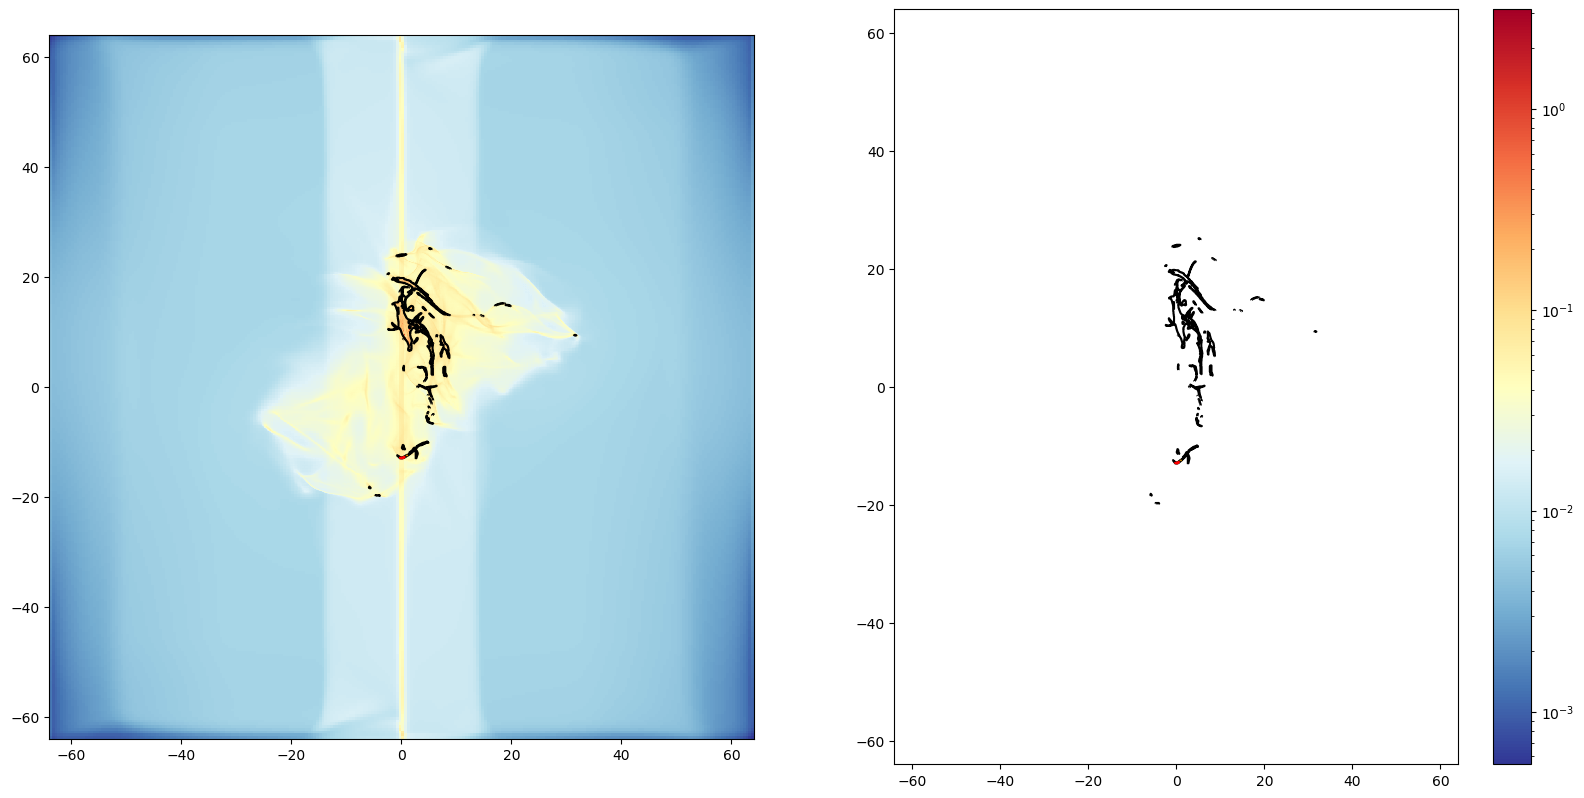

In [20]:
"""from astropy.io import fits
from matplotlib import ticker, cm"""

if __name__ == "__main__":
    fname = "./frb2048/v10_B10_th60_b05_0027_proj_frb.h5"
    ds = yt.load(fname)

    # list all field
    
    data=ds.all_data()["density"]
    num=int(np.sqrt(np.shape(data)[0]))

    # get density field and convert back to 2-d array
    dens = data.reshape(num,-1)
    
d = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=0.062,verbose=False)
#d = Dendrogram.compute(np.log(dens.value), min_value=np.log(0.1), min_delta=np.log(0.025), min_npix=np.log(0.062),verbose=False)
p = d.plotter()

fig, (ax, ax1) = plt.subplots(1, 2,figsize=(20,10))
im = ax.imshow(dens, norm=LogNorm(vmin=vmin, vmax=vmax), aspect='equal', origin='lower', extent=(l,r,b,t),interpolation='nearest',cmap='RdYlBu_r')

# Show contour for ``min_value``
p.plot_contour(ax, color='black', extent=(l,r,b,t))

# Highlight two branches
p.plot_contour(ax, structure=8, lw=3, colors='red', extent=(l,r,b,t))
p.plot_contour(ax, structure=24, lw=3, colors='orange', extent=(l,r,b,t))

# colorbar
cbar = plt.colorbar(im, orientation="vertical")
#ax.imshow(dens.value, origin='lower', interpolation='nearest', cmap=plt.cm.Blues, vmax=4.0)

# Show contour for ``min_value``
p.plot_contour(ax1, color='black', extent=(l,r,b,t))

# Highlight two branches
p.plot_contour(ax1, structure=8, lw=3, colors='red', extent=(l,r,b,t))
p.plot_contour(ax1, structure=24, lw=3, colors='orange', extent=(l,r,b,t))


In [3]:
d = Dendrogram.compute(dens.value, min_value=0.1, min_delta=0.025, min_npix=0.062)

Generating dendrogram using 9,015 of 4,194,304 pixels (0.2149343490600586% of data)

[>                                        ] 1%
[>                                        ] 2%
[=>                                       ] 3%
[=>                                       ] 4%
[==>                                      ] 5%
[==>                                      ] 6%
[===>                                     ] 7%
[===>                                     ] 8%
[===>                                     ] 9%
[====>                                    ] 11%
[====>                                    ] 12%
[=====>                                   ] 13%
[=====>                                   ] 14%
[======>                                  ] 15%
[======>                                  ] 16%
[=======>                                 ] 17%
[=======>                                 ] 18%
[=======>                                 ] 19%
[========>                                ] 21%
[========>  

In [25]:
#Pixels --from the simulation
2.44e-4*(2048**2)/(64.0053909775*2)**2

0.06245347814138639